# CAST
Collocated
Allong
Satellite
Track

### ToDo
- [x] read model data into a xarray dataset
- [x] read ADM data into a xarray dataset
- collocate model to ADM grid
  - [x] lon/lat
  - [x] time (not using right now)
  - [x] altitude/elevation
- example plot
  - [ ] bubble plot for ADM/EMEP/bias, per orbit
  - [ ] scatterplot, per orbit

# Conda environment at PPI/lustre

```bash
# load right (ana)conda module
module load aerocom/anaconda3-stable

# use altair for plotting
source activate altair

# start notebook
jupyter lab --no-browser --ip=$HOSTNAME.met.no

```

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
from glob import glob

for m in [np, pd, xr, alt]:
    print(m.__name__, m.__version__)

numpy 1.14.2
pandas 0.23.4
xarray 0.10.8
altair 2.2.2


# Read NetCDF files
list the emep forecast and adm orbit files for a given date

In [2]:
lustre = '/lustre/storeB/project/fou/kl/%s'
archive = dict(
    emepmodel = lustre%'emep/ModelRuns/ADM_Aeolus/EMEPmodel/CWF_12ST-%Y%m%d_hourInst.nc',
    topomodel = lustre%'emep/ModelRuns/ADM_Aeolus/EMEPmodel/MACC14_topo.nc',
    admaeolus = lustre%'admaeolus/data.rev.2A02/netcdf/2018-12/AE_OPER_ALD_U_N_2A_%Y%m%d*.DBL.nc',
)

date = pd.to_datetime('20181231')
ncfile = dict(
    emepmodel = date.strftime(archive['emepmodel']),
    topomodel = None, # waiting for topo file for MACC14 domain
    admaeolus = glob(date.strftime(archive['admaeolus'])),
)

for k, v in ncfile.items():
    if isinstance(v, str):
        print(k, v)
    elif isinstance(v, list):
        for f in v:
            print(k, f)


emepmodel /lustre/storeB/project/fou/kl/emep/ModelRuns/ADM_Aeolus/EMEPmodel/CWF_12ST-20181231_hourInst.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.2A02/netcdf/2018-12/AE_OPER_ALD_U_N_2A_20181231T053126033_005423993_002067_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.2A02/netcdf/2018-12/AE_OPER_ALD_U_N_2A_20181231T001202031_005423993_002063_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.2A02/netcdf/2018-12/AE_OPER_ALD_U_N_2A_20181231T130038029_005411999_002072_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.2A02/netcdf/2018-12/AE_OPER_ALD_U_N_2A_20181231T195450027_004740011_002076_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.2A02/netcdf/2018-12/AE_OPER_ALD_U_N_2A_20181231T225502032_005400005_002078_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.2A02/netcdf/2018-12/AE_OPER_ALD_U_N_2A_20181231T113102030_005400006_002071_0001.DBL.nc
admaeolus /lustre/

## EMEP forecat
model `Z_MID` + `topography`

In [3]:
emep = xr.open_dataset(ncfile['emepmodel']).rename({"Z_MID":"alt"}).set_coords("alt")
if ncfile['topomodel']:
    topo = xr.open_dataset(ncfile['topomodel']).topography.isel(time=0)
    topo["lon"] = emep.lon
    topo["lat"] = emep.lat
    emep["alt"] += topo
    
# fix units: file says 1/m
emep['EXT_350nm'] *= 1e3 # 1/m to 1e-3/m
emep['EXT_350nm'].attrs['units'] = "1/km"

emep

<xarray.Dataset>
Dimensions:         (ilev: 21, lat: 369, lev: 20, lon: 301, time: 25)
Coordinates:
  * lon             (lon) float64 -30.0 -29.75 -29.5 -29.25 -29.0 -28.75 ...
  * lat             (lat) float64 30.0 30.12 30.25 30.38 30.5 30.62 30.75 ...
  * lev             (lev) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 ...
  * ilev            (ilev) float64 0.09869 0.1347 0.1708 0.2068 0.2474 ...
  * time            (time) datetime64[ns] 2018-12-31 2018-12-31T01:00:00 ...
    alt             (time, lev, lat, lon) float32 ...
Data variables:
    P0              float64 ...
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    AOD_350nm       (time, lat, lon) float32 ...
    AOD_DUST_350nm  (time, lat, lon) float32 ...
    AOD_SS_350nm    (time, lat, lon) float32 ...
    AOD_SIA_350nm   (time, lat, lon) float32 ...
    AOD_500nm       (time, lat, lon) float32 ...
    AOD_550n

## ADM observations

In [4]:
adm = xr.open_dataset(ncfile['admaeolus'][0])

# fix units: file says 1/m but it is 1/Mm
adm['ec355aer'] *= 1e-3 # 1e-6/m to 1e-3/m
adm['ec355aer'].attrs['units'] = "1/km"

adm

<xarray.Dataset>
Dimensions:    (point: 10872)
Coordinates:
  * point      (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    time       (point) datetime64[ns] ...
    ec355aer   (point) float64 nan 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    bs355aer   (point) float64 ...
    latitude   (point) float64 ...
    longitude  (point) float64 ...
    altitude   (point) float64 ...
Attributes:
    product:              AE_OPER_ALD_U_N_2A_20181231T053126033_005423993_002...
    proc_stage:           N
    ref_doc:              AE-IF-DLR-L2A-004 03.05
    acquisition_station:  SVA_AS              
    proc_center:          APF   
    proc_time:            599556024.0
    software_ver:         ADM_L2aP/03.06
    baseline:             2A02                         
    sensing_start:        599549486.033888
    sensing_stop:         599554910.02745
    phase:                1
    cycle:                18
    rel_orbit:            56
    abs_orbit:            

# CAST

### Discard ADM outside the forecast domain

In [5]:
domain = dict(
    time = emep.time[[0, -1]].values,
    latitude = emep.lat[[0, -1]].values,
    longitude = emep.lon[[0, -1]].values,
    altitude = [0.0, emep.alt.isel(lev=0).max().values],
)
domain

{'time': array(['2018-12-31T00:00:00.000000000', '2019-01-01T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 'latitude': array([30., 76.]),
 'longitude': array([-30.,  45.]),
 'altitude': [0.0, array(15571.04394531)]}

In [6]:
in_range = lambda x, k: np.logical_and(x[k] >= domain[k][0], x[k] <= domain[k][1])
in_latlon = lambda x: np.logical_and(in_range(x, 'latitude'), in_range(x, 'longitude'))
in_domain = lambda x: np.logical_and(in_latlon(x), in_range(x, 'altitude'))
in_forecast=lambda x: np.logical_and(in_domain(x), in_range(x, 'time'))

mask = in_forecast(adm)
print('#points:   %6d'%adm.ec355aer.count())
print('#latlon:   %6d'%in_latlon(adm).sum())
print('#domain:   %6d'%in_domain(adm).sum())
print('#forecast: %6d'%mask.sum())

#points:     8137
#latlon:     1048
#domain:      930
#forecast:    930


### Filtered ADM

In [7]:
adm = adm.where(mask, drop=True)
adm.ec355aer

<xarray.DataArray 'ec355aer' (point: 930)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * point    (point) int64 483 484 485 486 487 488 489 490 491 492 493 494 ...
Attributes:
    long_name:      extinction @ 355nm
    standard_name:  volume_extinction_coefficient_in_air_due_to_ambient_aeros...
    units:          1/km

### Collocated forecast

In [8]:
collocate = lambda model, obs: model.load().sel(
    lon=obs.longitude,
    lat=obs.latitude,
#   alt=obs.altitude,
    time=obs.time,
    method='nearest'
)

In [9]:
%time emep = collocate(emep, adm)

emep.EXT_350nm

CPU times: user 5.61 s, sys: 208 ms, total: 5.82 s
Wall time: 5.84 s


<xarray.DataArray 'EXT_350nm' (point: 930, lev: 20)>
array([[0.      , 0.000643, 0.000747, ..., 0.012757, 0.012057, 0.013844],
       [0.      , 0.000643, 0.000747, ..., 0.012757, 0.012057, 0.013844],
       [0.      , 0.000643, 0.000747, ..., 0.012842, 0.012242, 0.01288 ],
       ...,
       [0.      , 0.001082, 0.001133, ..., 0.047839, 0.058477, 0.067583],
       [0.      , 0.001082, 0.001133, ..., 0.047839, 0.058477, 0.067583],
       [0.      , 0.001082, 0.001133, ..., 0.047839, 0.058477, 0.067583]],
      dtype=float32)
Coordinates:
    lon      (point) float64 24.5 24.5 24.25 24.25 24.25 24.25 24.25 24.25 ...
    lat      (point) float64 75.38 75.38 75.38 75.38 75.38 75.5 75.5 75.5 ...
  * lev      (lev) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 0.4114 ...
    time     (point) datetime64[ns] 2018-12-31T06:00:00 2018-12-31T06:00:00 ...
    alt      (point, lev) float32 14266.854 12584.203 11244.536 10069.766 ...
  * point    (point) int64 483 484 485 486 487 488 489 490 49

In [10]:
find_nearest = lambda arr, v: (np.abs(arr - v)).argmin()
find_level = lambda p: find_nearest(emep.alt.sel(point=p), adm.altitude.sel(point=p)).values

In [11]:
%time lev = xr.DataArray([find_level(p) for p in emep.point], dims='point', coords={'point':emep.point})

lev

CPU times: user 3.75 s, sys: 8 ms, total: 3.76 s
Wall time: 3.76 s


<xarray.DataArray (point: 930)>
array([ 0,  1,  2, ..., 13, 14, 15])
Coordinates:
  * point    (point) int64 483 484 485 486 487 488 489 490 491 492 493 494 ...

In [12]:
%time emep = emep.isel(lev=lev)

emep.EXT_350nm

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.78 ms


<xarray.DataArray 'EXT_350nm' (point: 930)>
array([0.      , 0.000643, 0.000747, ..., 0.081698, 0.08228 , 0.075726],
      dtype=float32)
Coordinates:
    lon      (point) float64 24.5 24.5 24.25 24.25 24.25 24.25 24.25 24.25 ...
    lat      (point) float64 75.38 75.38 75.38 75.38 75.38 75.5 75.5 75.5 ...
    lev      (point) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.2744 ...
    time     (point) datetime64[ns] 2018-12-31T06:00:00 2018-12-31T06:00:00 ...
    alt      (point) float32 14266.854 12584.203 11244.549 10069.96 8866.526 ...
  * point    (point) int64 483 484 485 486 487 488 489 490 491 492 493 494 ...
Attributes:
    long_name:           EXT_350nm
    units:               1/km
    class:               EXT:GROUP
    current_date_first:  [2018   12   31    0]
    numberofrecords:     25
    current_date_last:   [2019    1    1    0]

# Plots

In [13]:
obs = adm.rename({
    'altitude':'alt','latitude':'lat','longitude':'lon','ec355aer':'ext_355'
}).drop('bs355aer').to_dataframe()

obs.describe(percentiles=[.95, .99])

,ext_355,lat,lon,alt
count,930.000000,930.000000,930.000000,930.000000
mean,0.251974,53.162205,11.529864,6179.679031
std,5.674594,13.333433,5.188743,4198.540750
min,0.000000,30.232266,4.754403,653.410267
50%,0.000000,53.080489,10.318625,6198.096974
95%,0.000000,73.930457,22.132748,13763.406485
99%,1.698126,75.439536,24.176840,13778.162764
max,171.230184,75.455432,24.424758,13784.244996


In [14]:
mod = emep.rename({
    'EXT_350nm':'ext_355',
}).ext_355.drop('lev').to_dataframe()

mod.describe(percentiles=[.95, .99])

,lon,lat,alt,ext_355
count,930.000000,930.000000,930.000000,930.000000
mean,11.529032,53.162769,6188.306641,0.014394
std,5.187402,13.333372,4185.468750,0.038733
min,4.750000,30.250000,594.018799,0.000000
50%,10.250000,53.125000,5635.442383,0.003441
95%,22.250000,73.875000,13242.054395,0.064830
99%,24.250000,75.500000,14377.252236,0.212313
max,24.500000,75.500000,14558.252930,0.427119


In [15]:
cast = 'cast.json'
df = pd.merge(obs, mod, on='point', suffixes=('_obs', '_mod'))
df.reset_index().to_json(cast, orient="records")

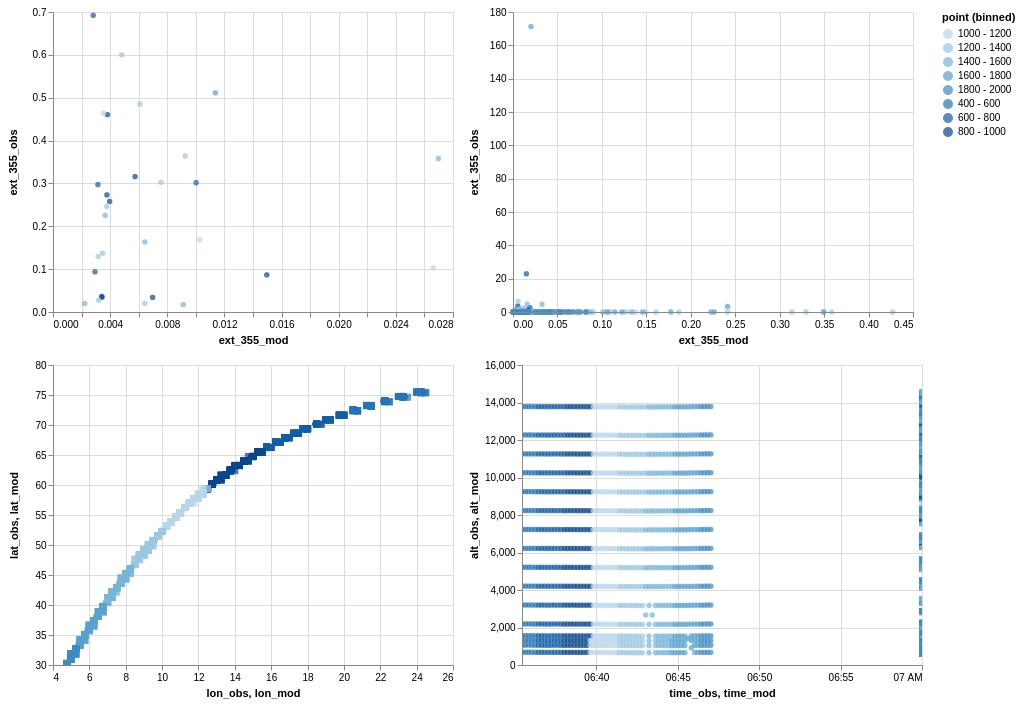

In [20]:
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(cast).encode(
    color=alt.condition(brush, alt.Color('point:O', bin=alt.Bin(maxbins=10)), alt.value('lightgray')),
)

lonlat = base.mark_circle().encode(
    alt.X('lon_obs:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat_obs:Q', scale=alt.Scale(zero=False)),
    tooltip=['point:O', 'time_obs:T', 'lon_obs:Q', 'lat_obs:Q', 'alt_obs:Q']
) + base.mark_square(size=50).encode(
    alt.X('lon_mod:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat_mod:Q', scale=alt.Scale(zero=False)),
    tooltip=['point:O', 'time_mod:T', 'lon_mod:Q', 'lat_mod:Q', 'alt_mod:Q']
).interactive()

timealt = base.mark_circle().encode(
    x='time_obs:T',
    y='alt_obs:Q',
    tooltip=['point:O', 'time_obs:T', 'alt_obs:Q',]
) + base.mark_square().encode(
    x='time_mod:T',
    y='alt_mod:Q',
    tooltip=['point:O', 'time_obs:T', 'alt_mod:Q',]
).interactive()

scatter = base.mark_circle().encode(
    y='ext_355_obs:Q',
    x='ext_355_mod:Q',
    tooltip=['point:O', 'time_obs:T', 'lat_obs:Q', 'alt_obs:Q', 'ext_355_obs:Q', 'ext_355_mod:Q',]
).add_selection(
    brush
)

scatter_clean = scatter.transform_filter(
    (alt.datum.ext_355_obs < 1) & (alt.datum.ext_355_obs > 0)
)

( scatter_clean | scatter ) & ( lonlat | timealt )

In [17]:
cast2 = 'cast2.json'
df = pd.concat({'obs':obs,'mod':mod}, axis=1, names=['dataset']).stack('dataset')
df.reset_index().to_json(cast2, orient="records")

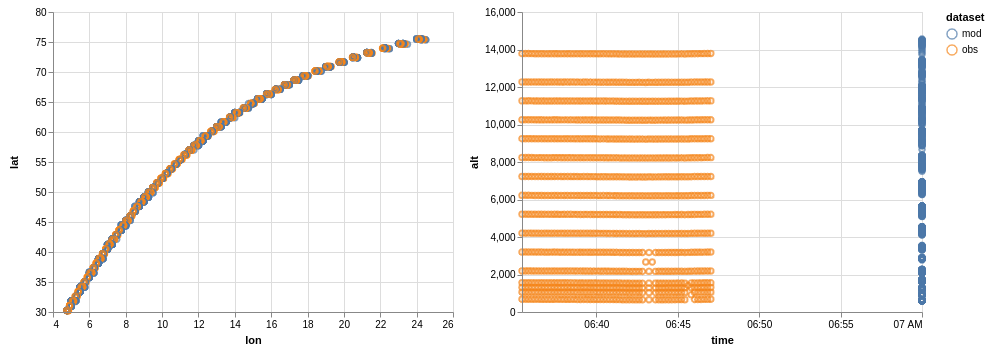

In [18]:
base = alt.Chart(cast2).mark_point().encode(
    color=alt.condition(brush, 'dataset:N', alt.value('lightgray')),
    tooltip=['dataset:N', 'point:O', 'time:T', 'lon:Q', 'lat:Q', 'alt:Q'],
).add_selection(
    brush
)#.interactive()

lonlat = base.encode(
    alt.X('lon:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat:Q', scale=alt.Scale(zero=False)),
)

timealt = base.encode(
    x='time:T',
    y='alt:Q',
)

lonlat | timealt

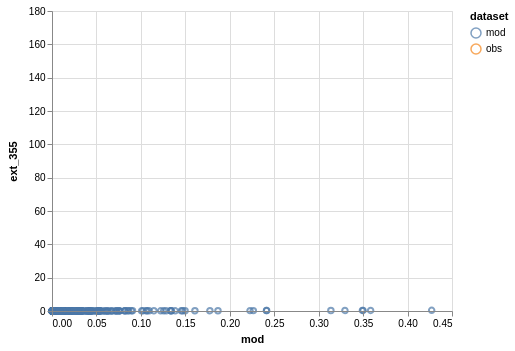

In [19]:
base.encode(
    y='ext_355:Q',
    x='mod:Q',
).transform_calculate(
    mod=alt.expr.if_(alt.datum.dataset == 'mod', alt.datum.ext_355, None),
    obs=alt.expr.if_(alt.datum.ext_355 > 0 and alt.datum.ext_355 < 1, alt.datum.ext_355, None),
)
